# Libraries

In [ ]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -U imgaug
!pip install imagecorruptions
!pip install jupyterplot
!pip install livelossplot --quiet
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch


  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-4u9ws3nr
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-4u9ws3nr
     |████████████████████████████████| 58 kB 5.7 MB/s 
     |████████████████████████████████| 376 kB 37.5 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.2.0-py3-none-any.whl size=88601 sha256=1598880b6f806d11c7c4584063cf20582e04862c41b06b45c23e905845bb1ca9
  Stored in directory: /tmp/pip-ephem-wheel-cache-mnat1a25/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=ca70fb837253faece6ec607aab92c348e8c7c4e5a78f48a7e9be9bdf5c34c16a
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-n

In [ ]:
import segmentation_models_pytorch as smp
import os
import json
import nibabel as nib
import numpy as np
from tqdm.notebook import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
import torch

!pip install jupyterplot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing

In [ ]:
"""
Load training data into images and labels lists

images list consists of CT scans -  numpy arrays of shape (512, 512, n_slices)
labels list consists of ground truth masks -  numpy arrays of shape (512, 512, n_slices), where:
    0 - background class
    1 - regions of consolidation class
"""

path = '/content/drive/MyDrive/medical-imaging-2021/data/data'
path_images = os.path.join(path, 'images')
path_labels = os.path.join(path, 'labels')
with open('/content/drive/MyDrive/medical-imaging-2021/training_data.json', 'r') as f:
    dict_training = json.load(f)

images = np.empty([1651, 512, 512])
labels = np.empty([1651, 512, 512])
temp = []
i_im = 0
i_l = 0
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

for entry in tqdm(dict_training):
    image = nib.load(os.path.join(path_images, entry['image'])[:-3])
    label = nib.load(os.path.join(path_labels, entry['label'])[:-3])

    temp = image.get_fdata()
    #temp = np.uint8(cv.normalize(temp, None, 0, 255, cv.NORM_MINMAX))
    l = len(temp[0][0])

    for j in range(l):
        #images[i_im] = clahe.apply(np.array(temp[:,:, j]))/255
        images[i_im] = np.array(temp[:,:, j])
        i_im += 1

    temp = label.get_fdata()

    for j in range(l):
        labels[i_l] = np.array(temp[:, :, j])
        i_l += 1

In [ ]:
def get_sliced(slice):
  temp = slice.get_fdata()
  labels = []
  l = len(temp[0][0])

  for j in range(l):
      labels.append(np.array(temp[:, :, j]))

  return labels 

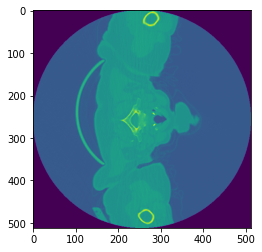

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images[1650])

X_train = images[:1401]
X_test = images[1401:]
del images
y_train = labels[:1401]
y_test = labels[1401:]
del labels

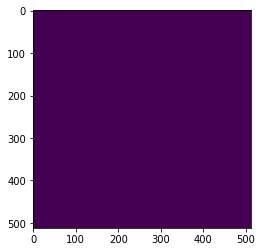

In [ ]:
plt.imshow(y_train[515])

# Извлекаем контуры для attention loss (Depricated)

In [ ]:
import cv2
contures_train = np.empty_like(y_train)
for idx, i in  enumerate(y_train):
    img = np.uint8(i* 255)
    imgtarget = np.zeros((512,512))
    contours, _ = cv2.findContours(img,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(imgtarget, contours, -1, 1, 1)
    contures_train[idx] = imgtarget


In [ ]:

import cv2
contures_test = np.empty_like(y_test)
for idx, i in  enumerate(y_test):
    img = np.uint8(i* 255)
    imgtarget = np.zeros((512,512))
    contours, _ = cv2.findContours(img,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(imgtarget, contours, -1, 1, 1)
    contures_test[idx] = imgtarget



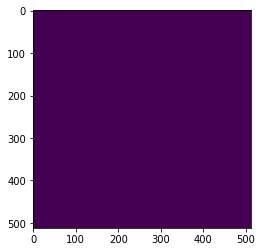

In [ ]:
plt.imshow(contures_train[515])

# Рассчитываем dist map для surface loss

In [ ]:
from scipy.ndimage import distance_transform_edt as distance
def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


# Аугментации

In [ ]:
import random
import torchvision
from albumentations import VerticalFlip, HorizontalFlip, RandomSizedCrop, Rotate,Compose,Resize,OneOf,RandomBrightness,RandomContrast,Normalize,HorizontalFlip,Blur,ElasticTransform,GridDistortion,OpticalDistortion,GaussNoise, RandomBrightnessContrast
SOURCE_SIZE = 512
TARGET_SIZE = 512
def Augment(X, y, cnt = None):
    if random.random() > 0.5:
        X = torchvision.transforms.functional.vflip(X)
        y = torchvision.transforms.functional.vflip(y)
        if cnt is not None:
            cnt = torchvision.transforms.functional.vflip(cnt)
    r = random.random()
    degs = [-20, 20, -15, 15, -10, 10, -5, 5]
    if 0.05 <= r < 0.7:
        deg = random.choice(degs)
        X = torchvision.transforms.functional.rotate(X, deg)
        y = torchvision.transforms.functional.rotate(y, deg)
        if cnt is not None: 
          cnt = torchvision.transforms.functional.rotate(cnt, deg)
    return X, y, cnt

# Непосредсвтенно датасет

In [ ]:
from torchvision.transforms import ToTensor, ToPILImage
import cv2

H, W = 512, 512
val_augs = Compose([
    Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])
class Dataset(torch.utils.data.Dataset):
    def __init__(self, imgs, mask, cont, aug = False):
        
        self.mask = mask
        self.imgs = imgs
        self.cont = cont
        self.aug = aug

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        augument = val_augs(image=self.imgs[index],mask=self.mask[index])
        X = augument['image']
        y = augument['mask']
        X = (ToTensor()(X))
        y = (ToTensor()(y))
        X = X.type(torch.float)
        y = y.type(torch.float)
        
        if self.cont is not None:
            augument = val_augs(image=self.imgs[index],mask=self.cont[index])
            cont = augument['mask']
            cont = (ToTensor()(cont))
            cont = cont.type(torch.float)
            if self.aug:
                X, y, cont = Augment(X, y, cont)
            return torch.stack([X],1).reshape(1,W,H), y, (ToTensor()(calc_dist_map(y.detach().numpy().astype(np.float).copy().reshape(W,H)))).reshape(1,W,H), cont
        if self.cont is  None:
            if self.aug:
                X, y, _ = Augment(X, y)
            return torch.stack([X],1).reshape(1,W,H) , y, (ToTensor()(calc_dist_map(y.detach().numpy().astype(np.float).copy().reshape(W,H)))).reshape(1,W,H), 0

training_set = Dataset(X_train, y_train, None, True)
validation_set = Dataset(X_test, y_test, None)

training_generator = torch.utils.data.DataLoader(training_set, batch_size =  8, shuffle = True)
validation_generator = torch.utils.data.DataLoader(validation_set, batch_size = 4, shuffle = False)

In [ ]:
from PIL import Image
def blend(image, mask):
    image = image.astype(np.float32)
    min_in = image.min()
    max_in = image.max()
    image = (image - min_in) / (max_in - min_in + 1e-8) * 255
    image = np.dstack((image, image, image)).astype(np.uint8)
    zeros = np.zeros_like(mask)
    mask = np.dstack((zeros, zeros, mask * 255)).astype(np.uint8)
    return Image.blend(
        Image.fromarray(image),
        Image.fromarray(mask),
        alpha=.2
    )

In [ ]:
from random import randint 
smpl = training_set[randint(0, len(validation_set))]


torch.Size([1, 512, 512])


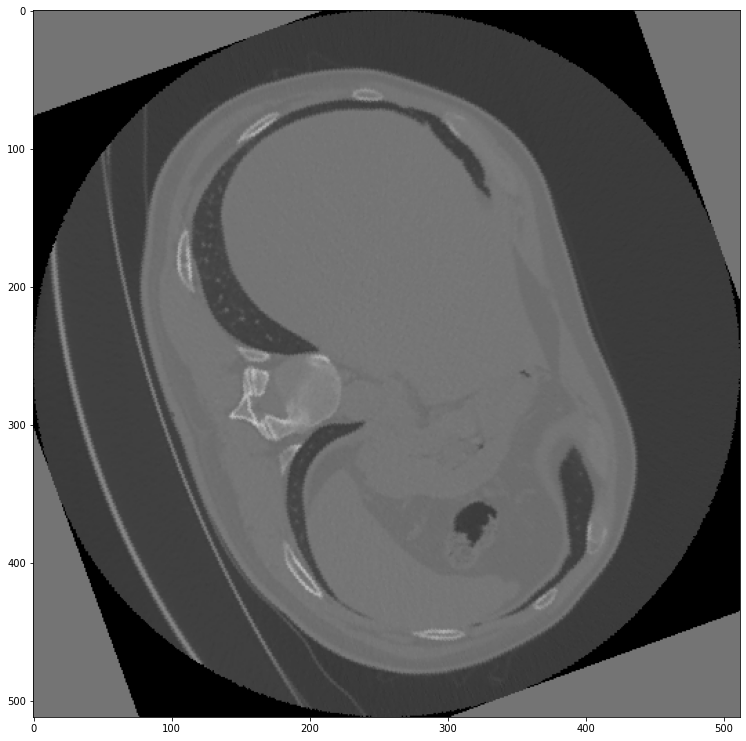

In [ ]:
print(smpl[0].shape)
plt.figure(figsize=(13,13))
plt.imshow(blend(smpl[0].detach().cpu().numpy().reshape(W,H), smpl[1].detach().cpu().numpy().reshape(W,H)), cmap = 'bone')

# Losses

In [ ]:
def surface_loss(y_pred, y_true_dist_map):
    multipled = y_pred * y_true_dist_map
    return multipled.mean()
def dice_loss(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))
ALPHA = 0.3
BETA = 0.7
from torch import nn 
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=0.1, alpha=ALPHA, beta=BETA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

# Training

In [ ]:
import torchvision.transforms
cuda = torch.device('cuda:0')
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 1
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation='sigmoid',
    in_channels = 1,
).to(cuda)
# model.load_state_dict(torch.load('/content/drive/MyDrive/BEST:0.6564364433288574_ep:45.pth'))
model = model.to(cuda)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, verbose=True)


Adjusting learning rate of group 0 to 5.0000e-03.


In [ ]:
# !mkdir /content/drive/MyDrive/Covid_lungs/Models/

In [ ]:

class AvgR(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = {'train':0, 'validation':0}
        self.avg = {'train':0, 'validation':0}
        self.sum = {'train':0, 'validation':0}
        self.count = {'train':0, 'validation':0}
        self.losses = {'train':[], 'validation':[]}

    def update(self, phase, val, n=1):
        self.val[phase] = val
        self.sum[phase]  += val * n
        self.count[phase]  += n
        self.avg[phase]  = self.sum[phase]  / self.count[phase] 
        self.losses[phase] .append(val)

    def show(self, phase):
        return torch.mean(torch.stack(self.losses[phase]))
class DiceScore(nn.Module):
    def __init__(self, trh=0.5, weight=None, size_average=True):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=0.1):
        targets = torch.round(targets)
        intersection = (inputs * targets).sum()                            
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        return dice_score

In [ ]:
from livelossplot import PlotLosses

def train(model, loaders, criterions, coeffs, metrics, optimizer, epochs = 100, lr_scheduler = None, device=torch.device('cpu')):
  liveloss = PlotLosses()
  bst_dice = 0
  for num_epoch in range(epochs):
    loss_recorders = {}
    loss_overall = AvgR()
    for i in criterions:
        loss_recorders[i] = AvgR()
    metric_recorders = {}
    for i in metrics:
        metric_recorders[i] = AvgR()
    lpllogs = {}
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        for idx, (x, y, dm, _) in enumerate(loaders[phase]):
            x = x.to(device).float()
            y = y.to(device).float()
            # edges = edges.to(dev??ice).float()
            loss = 0
            pred = model(x)
            loss2 = criterions['dice_loss'](pred, y)
            loss1 = criterions['BCE'](pred, y)
            loss3 = criterions['surface_loss'](pred,dm.to(device).float())
            
            loss =  coeffs['BCE']*loss1 + coeffs['dice_loss'] * loss2 + coeffs['surface_loss']*loss3
            loss_recorders['dice_loss'].update(phase, (loss2).data)
            loss_recorders['BCE'].update(phase, loss1.data)
            loss_recorders['surface_loss'].update(phase, loss3.data)
            loss_overall.update(phase, loss.data)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if (idx + 1) % 400 == 0 and lr_scheduler is not None: 
                    lr_scheduler.step()
            del loss
            for i in metrics:
                metric_recorders[i].update(phase, metrics[i](pred.detach().cpu(), y.detach().cpu()).data)
            del x
            del y
            del pred
            del loss1
            del dm
            del loss3
            del loss2
            torch.cuda.empty_cache()
        prefix = ''
        if phase == 'validation':
            prefix = 'val_'
            if metric_recorders["DiceScore"].show("validation") > bst_dice:
                bst_dice = metric_recorders["DiceScore"].show("validation")
                print(f"Saving epoch {num_epoch}")
                torch.save(model.state_dict(), f'./BEST:{metric_recorders["DiceScore"].show("validation")}_ep:{num_epoch}.pth')
                torch.save(model.state_dict(), f'/content/drive/MyDrive/BEST:{metric_recorders["DiceScore"].show("validation")}_ep:{num_epoch}.pth')

        for i in loss_recorders:
            lpllogs[prefix + i] = loss_recorders[i].show(phase)
        for i in metric_recorders:
            lpllogs[prefix + i] = metric_recorders[i].show(phase)
        lpllogs[prefix + 'overall loss'] = loss_overall.show(phase)
    liveloss.update(lpllogs)
    liveloss.send()
  return model 
        
      
            

    
    
    


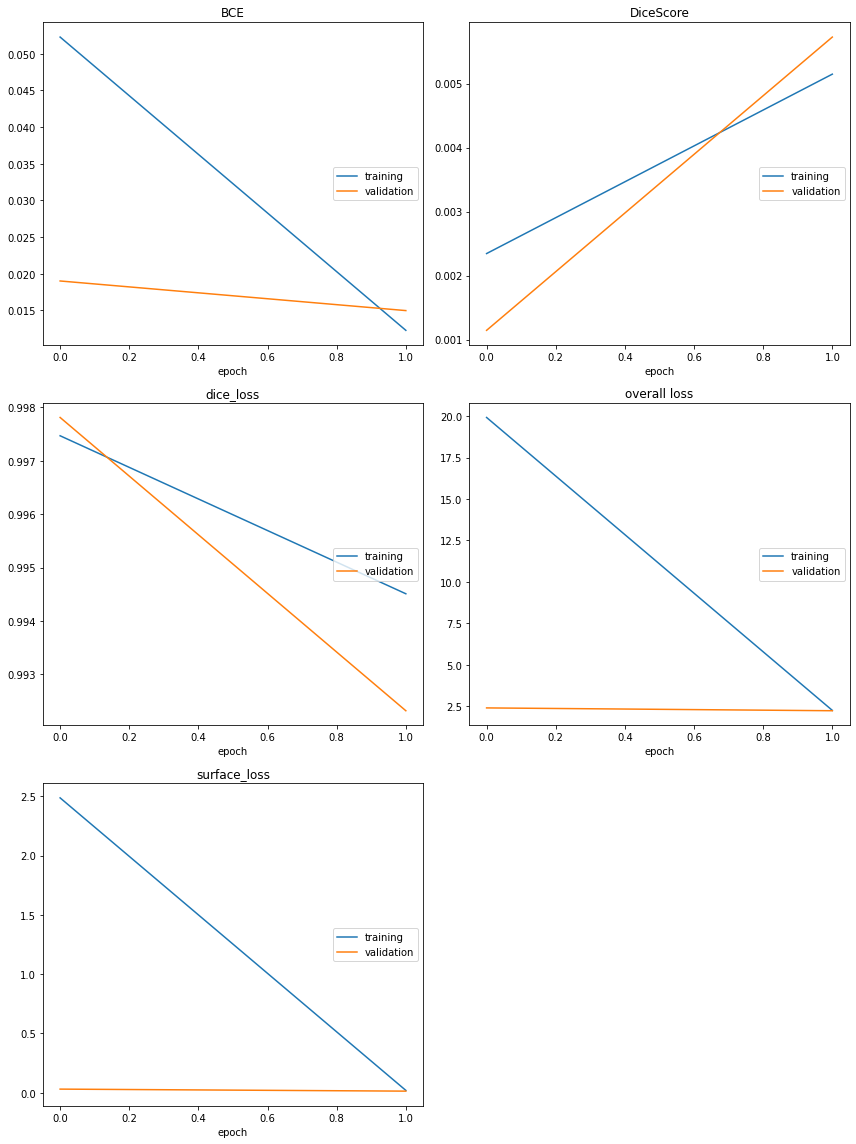

BCE
	training         	 (min:    0.012, max:    0.052, cur:    0.012)
	validation       	 (min:    0.015, max:    0.019, cur:    0.015)
DiceScore
	training         	 (min:    0.002, max:    0.005, cur:    0.005)
	validation       	 (min:    0.001, max:    0.006, cur:    0.006)
dice_loss
	training         	 (min:    0.995, max:    0.997, cur:    0.995)
	validation       	 (min:    0.992, max:    0.998, cur:    0.992)
overall loss
	training         	 (min:    2.253, max:   19.919, cur:    2.253)
	validation       	 (min:    2.232, max:    2.402, cur:    2.232)
surface_loss
	training         	 (min:    0.020, max:    2.486, cur:    0.020)
	validation       	 (min:    0.014, max:    0.031, cur:    0.014)


KeyboardInterrupt: ignored

In [ ]:
model.train()
model = train(
        model = model,
        loaders = {'train' : training_generator, 'validation' : validation_generator},
        criterions = {'dice_loss' :  dice_loss, 'BCE' : torch.nn.BCELoss(), 'surface_loss' : surface_loss},
        coeffs = {'dice_loss' : 2, 'BCE' : 10, 'surface_loss' : 7},
        metrics = { 'DiceScore': DiceScore()},
        optimizer = optimizer, 
        device = cuda, 
        lr_scheduler = lr_scheduler
    )




# Inference

In [ ]:
import torch

model.eval()

In [ ]:
# del images_testig

In [ ]:
path = '/content/drive/MyDrive/lungs/data/data'
path_images = os.path.join(path, 'images')
path_labels = os.path.join(path, 'labels')
with open('/content/drive/MyDrive/lungs/testing_data.json', 'r') as f:
    dict_testing = json.load(f)

images_testig = []
for entry in tqdm(dict_testing):
    image = nib.load(os.path.join(path_images, entry['image'])[:-3])
    
    images_testig.append((Path(entry['image']).stem.replace('.nii', ''), image.get_fdata()))

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
images_testig[0][1].shape

(512, 512, 41)

In [ ]:
images_testig[6][1].shape[-1]

33

In [ ]:
all_masks = {i[0] : i[1] for i in all_masks}

In [ ]:
all_masks['study_0293'][0].shape

(512, 512)

In [ ]:
images_testig[0]

('study_0258', memmap([[[-2048., -2048., -2048., ..., -2048., -2048., -2048.],
          [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
          [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
          ...,
          [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
          [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
          [-2048., -2048., -2048., ..., -2048., -2048., -2048.]],
 
         [[-2048., -2048., -2048., ..., -2048., -2048., -2048.],
          [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
          [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
          ...,
          [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
          [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
          [-2048., -2048., -2048., ..., -2048., -2048., -2048.]],
 
         [[-2048., -2048., -2048., ..., -2048., -2048., -2048.],
          [-2048., -2048., -2048., ..., -2048., -2048., -2048.],
          [-2048., -2048., -2048., ..., 

In [ ]:
thresh = 0.99
n_id = 10

for i in range(n_id):
    n_imgs = images_testig[i][1].shape[-1]

    name = images_testig[i][0]
    
    # print(n_imgs)
    for j in range(n_imgs):
        # inp = images_testig[i][:, :, j]

        # inp = torch.from_numpy(np.array(inp))
        # inp = inp.to(cuda)
        # inp = inp.type(torch.float)
        # inp = inp.view(-1, 1, 512, 512)

        # res = model(inp)
        # res = res.cpu()
        # outp = res.detach().numpy()[0][0]

        # outp /= np.max(outp)
        # outp[outp >= thresh] = 1
        # outp[outp < thresh] = 0

        images_testig[i][1][:, :, j] = all_masks[name][j]
        

In [ ]:
images_testig

[('study_0258', memmap([[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
  
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
  
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
  
          ...,
  
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
          

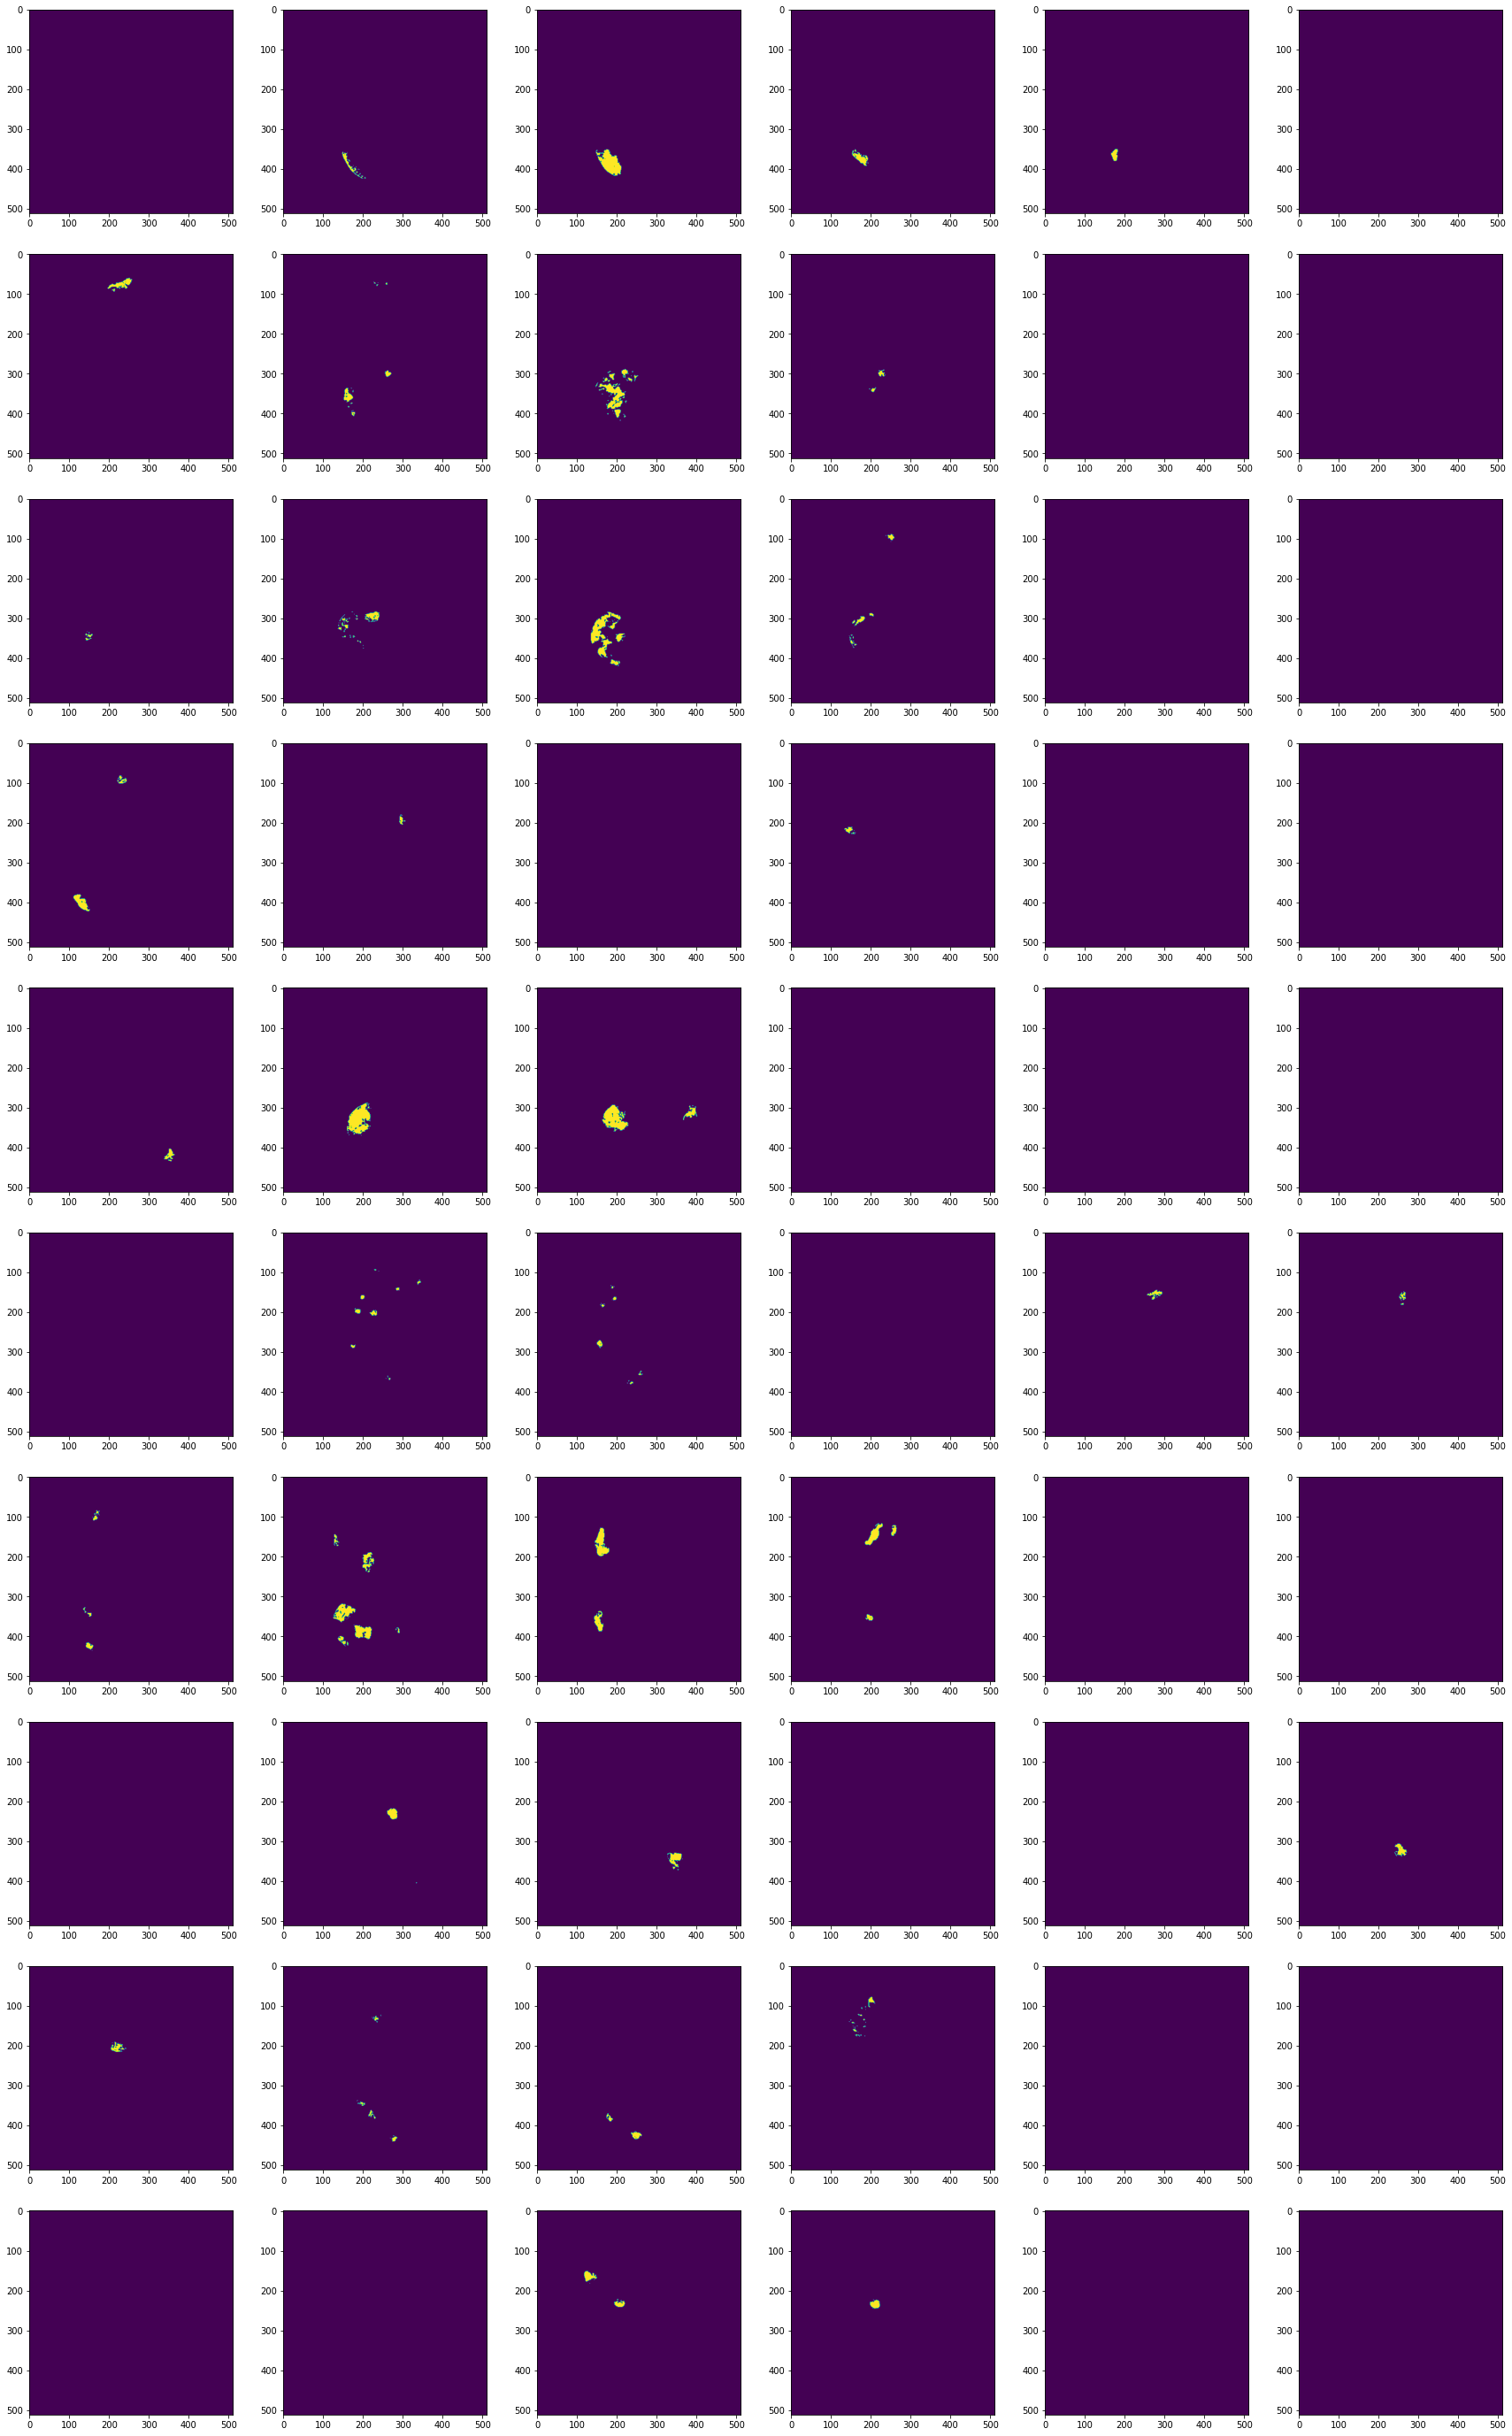

In [ ]:
# Visualize some of the predictions
labels_predicted = preds

slices_num = (10, 15, 20, 25, 30, 32)
#slices_num = (15,16,17,18,19,20,21)
n_slices = len(slices_num)

figure = plt.figure(figsize=(30, 50))
for j in range(10):
    for i in range(n_slices):
        ax = figure.add_subplot(10, n_slices,  j*n_slices + i + 1)
        ax.imshow(labels_predicted[j][:, :, slices_num[i]])

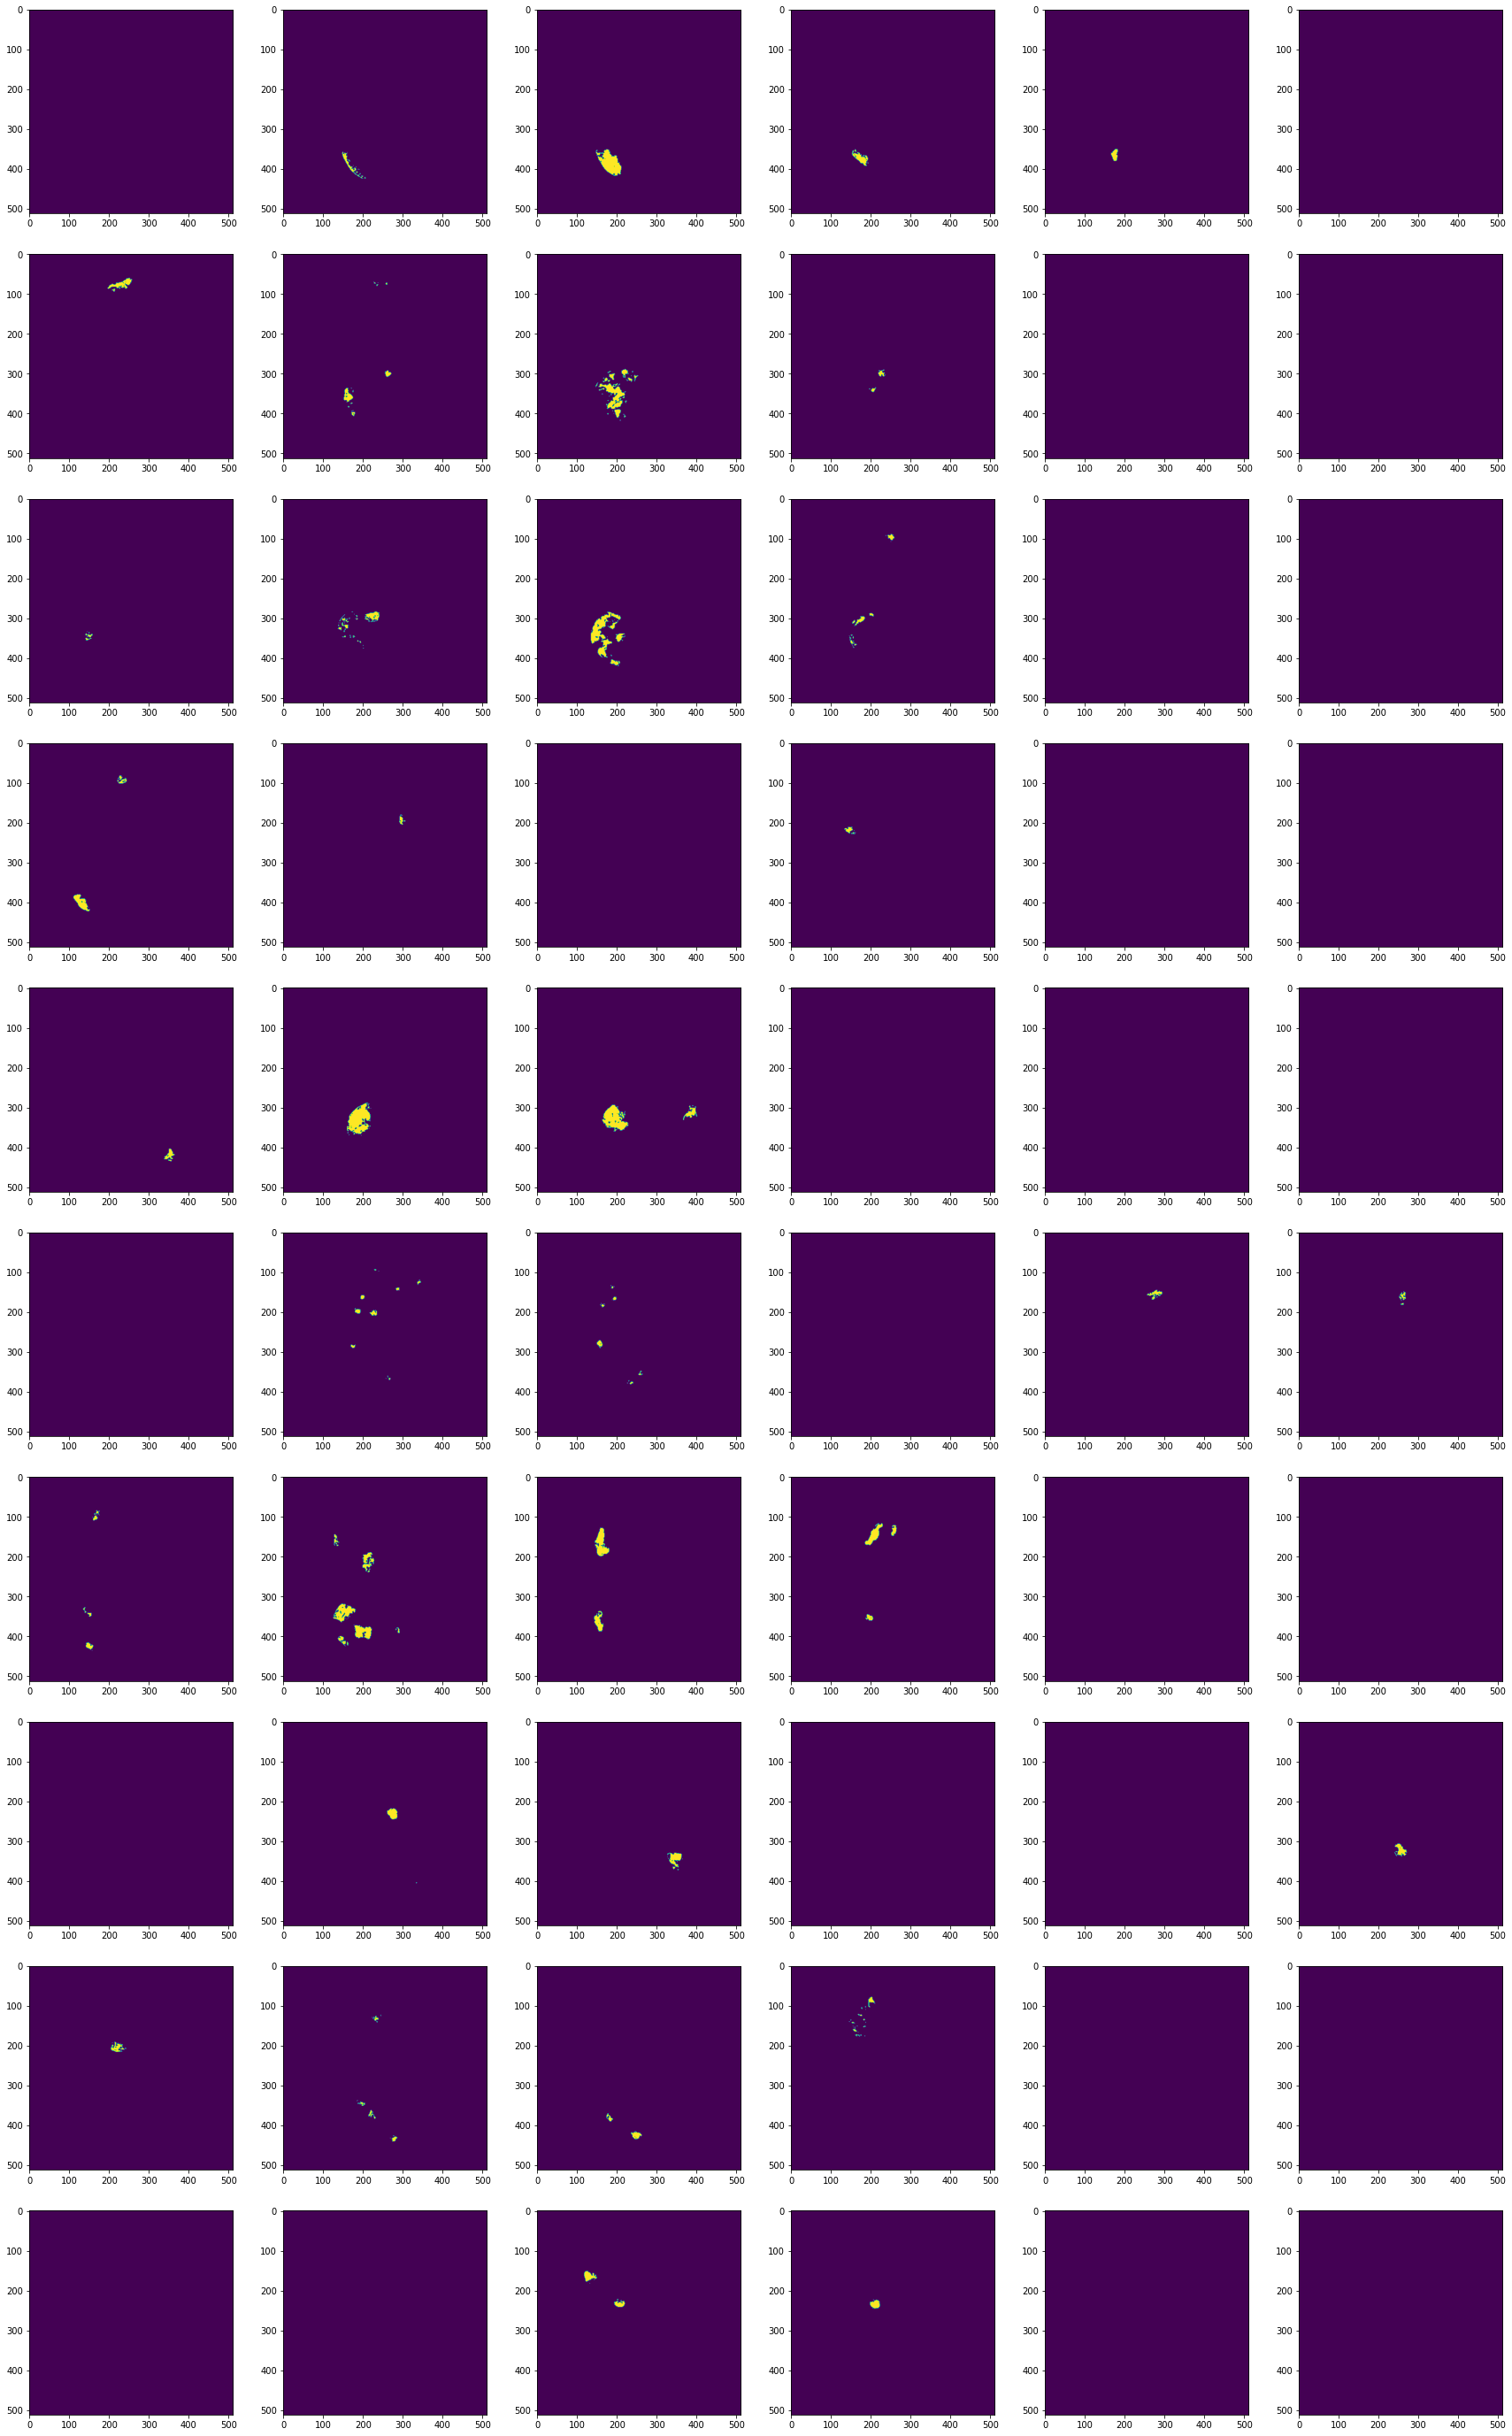

In [ ]:
# Visualize some of the predictions
labels_predicted = preds

slices_num = (10, 15, 20, 25, 30, 32)

n_slices = len(slices_num)

figure = plt.figure(figsize=(30, 50))
for j in range(10):
    for i in range(n_slices):
        ax = figure.add_subplot(10, n_slices,  j*n_slices + i + 1)
        ax.imshow(labels_predicted[j][:, :, slices_num[i]])

In [ ]:
import os 
from pathlib import Path

all_tests = [os.path.join('/content/drive/MyDrive/lungs/test', i) for i in os.listdir('/content/drive/MyDrive/lungs/test')]

In [ ]:
all_tests

['/content/drive/MyDrive/lungs/test/study_0293_mask.nii',
 '/content/drive/MyDrive/lungs/test/study_0292_mask.nii',
 '/content/drive/MyDrive/lungs/test/study_0258_mask.nii',
 '/content/drive/MyDrive/lungs/test/study_0275_mask.nii',
 '/content/drive/MyDrive/lungs/test/study_0302_mask.nii',
 '/content/drive/MyDrive/lungs/test/study_0277_mask.nii',
 '/content/drive/MyDrive/lungs/test/study_0304_mask.nii',
 '/content/drive/MyDrive/lungs/test/study_0267_mask.nii',
 '/content/drive/MyDrive/lungs/test/study_0280_mask.nii',
 '/content/drive/MyDrive/lungs/test/study_0279_mask.nii']

In [ ]:
all_masks = [(Path(i).stem.replace('_mask', ''), get_sliced(nib.load(i))) for i in all_tests]

In [ ]:
len(all_masks[0][1])
all_masks[0][1][0].shape

(512, 512)

In [ ]:
preds = [i[1] for i in images_testig]

In [ ]:
np.sum(preds[0].T.flatten() == 1)

23808

In [ ]:
preds[0]

np.where(preds[0].T.flatten() == 1)[0]

array([2984875, 2984876, 2984877, ..., 7957859, 7957860, 7957861])

In [ ]:
preds[0]

np.where(preds[0].T.flatten() == 1)[0]

array([2550464, 2571128, 2571456, ..., 9076796, 9097706, 9097747])

In [ ]:
# Execute this cell for submission file generation 
import csv

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2

    print(dots)

    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
      
    print(run_lengths)

    return [str(item) for item in run_lengths]

with open("./sample.csv", "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for idx, (_id, patient) in tqdm(enumerate(images_testig)):
        submission_writer.writerow([
                f"{_id}",
                " ".join([str(0), str(124)])
            ])

0it [00:00, ?it/s]

In [ ]:
del labels_predicted